In [1]:
#!/usr/bin/env python

import sys
import os
import argparse
import shutil
import numpy as np
import netCDF4 as nc
import multiprocessing as mp
from glob import glob
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
def fill_nan_with_last_valid_inplace(file_path):
    print(f"Processing file (in-place): {file_path}")

    with nc.Dataset(file_path, 'r+') as ds:
        for var_name, varin in ds.variables.items():
            if varin.ndim != 4 or varin.shape[0] == 0:
                continue  # skip variables that are not 4D or have no time dimension

            print(f"  Filling variable: {var_name}")
            data = varin[0, :, :, :]  # time index 0, shape (levels, lat, lon)
            filled_data = data.copy()

            nlev, nlat, nlon = data.shape

            for i in range(nlat):
                for j in range(nlon):
                    column = data[:, i, j]
                    last_valid = None
                    for k in range(nlev):
                        if column[k] != 0.0:
                            last_valid = column[k]
                        elif last_valid is not None:
                            filled_data[k, i, j] = last_valid

            varin[0, :, :, :] = filled_data

In [2]:
input_dir = '/g/data/tm70/ek4684/esm16_bathy_tests/archive/restart830/ocean/'
input_files = glob(os.path.join(input_dir, 'ocean_density.res.nc'))
input_files.sort()

In [3]:
input_files

['/g/data/tm70/ek4684/esm16_bathy_tests/archive/restart830/ocean/ocean_density.res.nc']

In [4]:
# Number of processes
nprocs = 7
with mp.Pool(nprocs) as pool:
    pool.map(fill_nan_with_last_valid_inplace, input_files)

NameError: name 'fill_nan_with_last_valid_inplace' is not defined

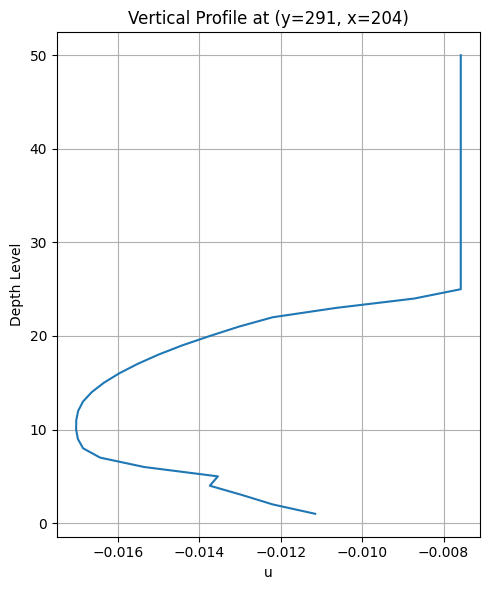

In [5]:
# Load file
file = os.path.join(input_dir, os.path.basename('ocean_velocity.res.nc'))
ds = nc.Dataset(file)

# Extract variables
age = ds.variables['v'][0]  # Shape: (z, y, x)
z = ds.variables['zaxis_1'][:]

# Choose a sample (lat, lon) location
lat_idx = 291  # midpoint
lon_idx = 204  # midpoint

profile = age[:, lat_idx, lon_idx]

plt.figure(figsize=(5, 6))
plt.plot(profile, z)
#plt.gca().invert_yaxis()
plt.title(f"Vertical Profile at (y={lat_idx}, x={lon_idx})")
plt.xlabel("u")
plt.ylabel("Depth Level")
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
file

'/g/data/tm70/ek4684/esm16_bathy_tests/archive/restart830/ocean/ocean_velocity.res.nc'